# FFT 频谱分析详解

本笔记本复现 `spectrum_analysis.py` 的流程，并在每个步骤结合离散时间傅里叶变换（DTFT/DFT）公式说明其数学原理。


## DFT 回顾

给定长度为 $N$ 的离散信号 $x[n]$，其离散傅里叶变换定义为
$
X[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-j 2 \pi k n / N}, \quad k = 0, 1, \dots, N-1.
$
逆变换可以还原出 $x[n]$：
$
x[n] = \frac{1}{N} \sum_{k=0}^{N-1} X[k] \cdot e^{j 2 \pi k n / N}.
$
每个系数 $X[k]$ 对应频率 $f_k = k \cdot \frac{F_s}{N}$ 的复指数基，幅度为 $|X[k]|$、相位为 $\angle X[k]$。快速傅里叶变换（FFT）将 DFT 计算复杂度降为 $O(N \log N)$。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


## 步骤 1 · 采样参数
以采样率 $F_s$ 将连续时间信号离散化，时间步长为 $T = 1/F_s$，对应的时间向量为 $t_n = nT,\; n \in [0, N-1]$。更高的 $F_s$ 可提升奈奎斯特频率 ($F_s/2$)，而频率分辨率 $\Delta f = F_s/N$ 由记录长度 $N$ 决定。


In [2]:
Fs = 1000            # 采样频率 (Hz)
T = 1.0 / Fs         # 采样周期 (s)
L = 1500             # 样本数量（记录长度）
t = np.arange(0, L) * T


## 步骤 2 · 复合测试信号
构建含有两组正弦波与白噪声的信号，以模拟被采样的模拟波形：
$
x[n] = 0.7 \sin(2\pi \cdot 50 t_n) + 1.0 \sin(2\pi \cdot 120 t_n) + w[n].
$
线性叠加展示了不同频率分量如何在频谱中形成峰值，同时噪声抬高频谱底噪。


In [3]:
# S = 0.7 * np.sin(2 * np.pi * 50 * t) + 1.0 * np.sin(2 * np.pi * 120 * t)
S =  1.0 * np.sin(2 * np.pi * 120 * t)
noise = 1.5 * np.random.randn(len(t))
signal_with_noise = S + noise


## 步骤 3 · FFT 计算
对噪声信号执行 FFT，可得到其 DFT 采样值 $Y[k]$。为了得到单边幅度谱，使用
$
P_2[k] = \frac{|Y[k]|}{N}, \quad P_1[k] =
\begin{cases}
P_2[k], & k = 0 \text{ 或 } k = N/2,\\
2P_2[k], & 其他情况,
\end{cases}
$
这样在舍弃实信号固有的共轭负频率时仍能保持总能量不变。


In [4]:
Y = np.fft.fft(signal_with_noise)
P2 = np.abs(Y / L) # Y[k]是L个时域样本计算得到的结果，所以除以L来归一化。
P1 = P2[: L // 2 + 1]
P1[1:-1] = 2 * P1[1:-1]
f = Fs * np.arange(0, L // 2 + 1) / L


## 步骤 4 · 标识主导频点
当 $|X[k]|$ 相比周围频点更突出时即形成峰值。`find_peaks` 的 `prominence` 参数要求候选峰与邻近谷值至少相差一定高度，从而抑制纯噪声造成的细小波动。


In [5]:
peaks, _ = find_peaks(P1, prominence=0.5)

print("Detected dominant frequencies")
print("-" * 30)
if peaks.size:
    for idx in peaks:
        print(f"f = {f[idx]:6.2f} Hz | amplitude = {P1[idx]:.2f}")
else:
    print("No peaks exceeded the chosen prominence.")


Detected dominant frequencies
------------------------------
f = 120.00 Hz | amplitude = 1.04


## 步骤 5 · 可视化解读
时域子图展示了噪声如何掩盖正弦分量，而单边频谱揭示其离散频率位置。标记峰值频率可以直观对应“主导频率”与其所在的最大 $|X[k]|$ 频点。


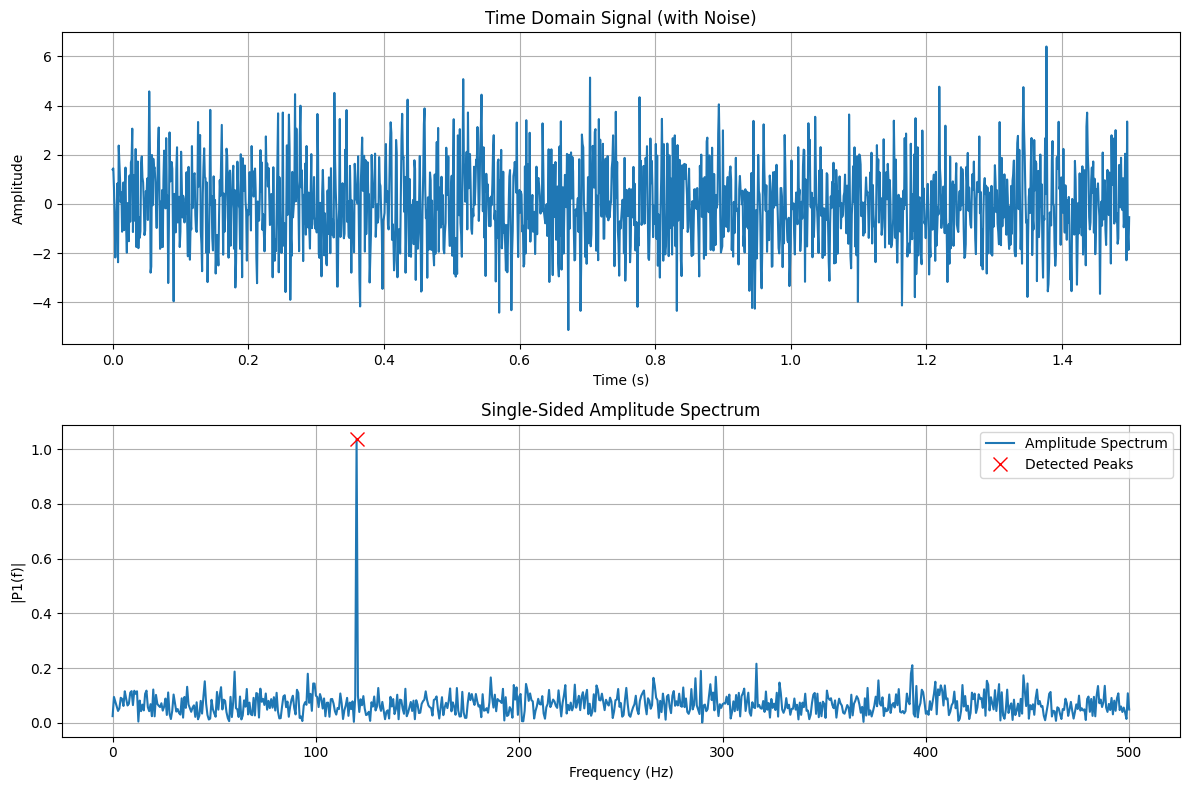

In [6]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, signal_with_noise)
plt.title('Time Domain Signal (with Noise)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(f, P1, label='Amplitude Spectrum')
plt.plot(f[peaks], P1[peaks], 'x', color='red', markersize=10, label='Detected Peaks')
plt.title('Single-Sided Amplitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|P1(f)|')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## 步骤 6 · 动态特性评估
在 FFT 结果基础上，可以进一步统计模拟/数模系统的关键动态指标：
- **信号功率** $P_{\text{sig}}$：基波分量的均方功率，$P = A_{\text{rms}}^2 = (A/\sqrt{2})^2$。
- **噪声功率** $P_{\text{noise}}$：除去直流、基波与若干谐波，并对其附近若干个 FFT 频点设置警戒带宽后剩余的功率之和，避免泄漏能量计入噪声。
- **信噪比 (SNR)**：
  $
  \text{SNR}_{\text{dB}} = 10 \log_{10} \left(\frac{P_{\text{sig}}}{P_{\text{noise}}}\right)
  $
- **有效位数 (ENOB)**：
  $
  \text{ENOB} = \frac{\text{SNR}_{\text{dB}} - 1.76}{6.02}
  $
- **总谐波失真 (THD)**：将多阶谐波功率与基波功率相比。
- **杂散自由动态范围 (SFDR)**：基波幅度与除基波外最大杂散幅度之比。

以下单元将自动识别基波、估算 2~5 次谐波功率，并在噪声功率计算中为每个信号频点设置警戒带宽，防止泄漏能量被误计为噪声。


In [ ]:
def compute_dynamic_metrics(P1, f, fs, peak_indices, harmonic_count=5, guard_bins=2):
    spectrum = np.asarray(P1)
    freq_axis = np.asarray(f)
    peak_indices = np.asarray(peak_indices)
    eps = 1e-20

    if spectrum.size < 2:
        raise ValueError("频谱长度不足以计算动态指标。")

    candidates = peak_indices if peak_indices.size else np.arange(1, spectrum.size)
    fundamental_idx = int(candidates[np.argmax(spectrum[candidates])])

    fundamental_freq = freq_axis[fundamental_idx]
    fundamental_amp = spectrum[fundamental_idx]
    fundamental_power = 0.5 * fundamental_amp ** 2

    harmonic_records = []
    harmonic_indices = []
    for order in range(2, harmonic_count + 1):
        target_freq = order * fundamental_freq
        if target_freq >= fs / 2:
            break
        idx = int(np.argmin(np.abs(freq_axis - target_freq)))
        harmonic_indices.append(idx)
        harmonic_records.append(
            {
                "order": order,
                "freq": freq_axis[idx],
                "amp": spectrum[idx],
                "power": 0.5 * spectrum[idx] ** 2,
            }
        )

    noise_mask = np.ones_like(spectrum, dtype=bool)

    def notch(mask, center, width):
        start = max(0, center - width)
        stop = min(mask.size, center + width + 1)
        mask[start:stop] = False

    notch(noise_mask, 0, guard_bins)  # DC
    notch(noise_mask, fundamental_idx, guard_bins)
    for idx in harmonic_indices:
        notch(noise_mask, idx, guard_bins)

    noise_power = np.sum(0.5 * np.square(spectrum[noise_mask]))
    harmonics_power = sum(record["power"] for record in harmonic_records) if harmonic_records else 0.0
    spur_indices = np.where(noise_mask)[0]
    spur_amplitude = spectrum[spur_indices].max() if spur_indices.size else 0.0

    signal_power_db = 10 * np.log10(fundamental_power + eps)
    noise_power_db = 10 * np.log10(noise_power + eps)
    snr_db = 10 * np.log10((fundamental_power + eps) / (noise_power + eps))
    enob = (snr_db - 1.76) / 6.02
    thd_db = (
        10 * np.log10((harmonics_power + eps) / (fundamental_power + eps))
        if harmonic_records
        else float("-inf")
    )
    sfdr_db = (
        20 * np.log10((fundamental_amp + eps) / (spur_amplitude + eps))
        if spur_amplitude > 0
        else float("inf")
    )

    return {
        "fundamental_freq": fundamental_freq,
        "fundamental_amp": fundamental_amp,
        "signal_power": fundamental_power,
        "signal_power_db": signal_power_db,
        "noise_power": noise_power,
        "noise_power_db": noise_power_db,
        "snr_db": snr_db,
        "enob": enob,
        "thd_db": thd_db,
        "sfdr_db": sfdr_db,
        "harmonics": harmonic_records,
    }


def format_db(value):
    if np.isposinf(value):
        return "+∞ dB"
    if np.isneginf(value):
        return "-∞ dB"
    return f"{value:.2f} dB"


metrics = compute_dynamic_metrics(P1, f, Fs, peaks, harmonic_count=5, guard_bins=2)

print(f"基波频率: {metrics['fundamental_freq']:.2f} Hz")
print(
    f"信号功率: {metrics['signal_power']:.4e} ({format_db(metrics['signal_power_db'])})"
)
print(
    f"噪声功率: {metrics['noise_power']:.4e} ({format_db(metrics['noise_power_db'])})"
)
print(f"SNR: {format_db(metrics['snr_db'])}")
print(f"ENOB: {metrics['enob']:.2f} bit")
print(f"THD: {format_db(metrics['thd_db'])}")
print(f"SFDR: {format_db(metrics['sfdr_db'])}")

if metrics["harmonics"]:
    print("\n谐波统计（幅度单位与 P1 一致）:")
    for record in metrics["harmonics"]:
        print(
            f"{record['order']} 次谐波 -> {record['freq']:.2f} Hz, "
            f"幅度 = {record['amp']:.3f}, 功率 = {record['power']:.3e}"
        )
else:
    print("\n可用频率范围内无可统计的谐波。")


基波频率: 120.00 Hz
信号功率: 5.3801e-01 (-2.69 dB)
噪声功率: 2.1979e+00 (3.42 dB)
SNR: -6.11 dB
ENOB: -1.31 bit
THD: -18.00 dB
SFDR: 13.63 dB

谐波统计（幅度单位与 P1 一致）:
2 次谐波 -> 240.00 Hz, 幅度 = 0.082, 功率 = 3.355e-03
3 次谐波 -> 360.00 Hz, 幅度 = 0.033, 功率 = 5.577e-04
4 次谐波 -> 480.00 Hz, 幅度 = 0.096, 功率 = 4.613e-03
